In [1]:
#### ALL NOTEBOOK SHOULD HAVE SOME VERSION OF THIS #####################################
########################################################################################
%load_ext autoreload
%autoreload 2
import os
import sys

currentdir = os.getcwd()
# go to root directory. change the # of os.path.dirnames based on where currentdir is
parentdir = os.path.dirname(os.path.dirname(currentdir)) 
# chek where I'm at. if I go too far up the tree, go back
if 'Protein-Purification-Model-Public' not in parentdir: parentdir = currentdir
if parentdir not in sys.path: sys.path.insert(0,parentdir)
########################################################################################

In [2]:
import utils
from visualization.simple_data_vis import histograms
import surrogate_models.dab_nn_defs as engine
import kerastuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# load easy data to test models with
train, test = tf.keras.datasets.boston_housing.load_data(path="boston_housing.npz", test_split=0.2, seed=113)
x =  ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']    
y = ['price',]
dataset = 'Boston Housing'

In [4]:
# standarize inputs
train_x, test_x = utils.preprocessing([pd.DataFrame(train[0], columns=x),pd.DataFrame(test[0], columns=x)])
# could also try standarizing outputs in a similar way (call utils.preprocessing again)
train = (train_x, pd.DataFrame(train[1], columns=y))
test = (test_x, pd.DataFrame(test[1], columns=y))

In [5]:
# define models to test out
lr = engine.create_deterministic_linear_regressor(
    FEATURE_NAMES = x,
    TARGET_NAMES = y, 
    name = 'DLR'+'boston'
)

dnn = engine.create_deterministic_nn(
    FEATURE_NAMES = x,
    TARGET_NAMES = y,
    hidden_units = [16,8,4],
    name = 'DNN'+'boston'
)

pnn = engine.create_probabilistic_nn(
    FEATURE_NAMES = x,
    TARGET_NAMES = y,
    train_size = len(train[0]),
    hidden_units = [4,],
    name = 'PNN'+'boston'
)

models = [lr, dnn, pnn]

In [6]:
# lets check a NN structure
pnn.summary()

Model: "PNNboston"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 13)]              0         
_________________________________________________________________
dense_variational (DenseVari (None, 4)                 1652      
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 1,657
Trainable params: 1,657
Non-trainable params: 0
_________________________________________________________________


In [7]:
# train all the models under the same conditions
learning_rate = 0.1
epochs = 300
optimizer = 'Adam'

for m in models:
    engine.run_experiment(
        model = m, 
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam,
        learning_rate = learning_rate,
        num_epochs = epochs,
        train_dataset = train, 
        test_dataset = test,
        verbose = 0
        )

Start training the model DLRboston ...
Model training finished.
Train MSE: 17.382
Evaluating model performance...
Test MSE: 31.282
Start training the model DNNboston ...
Model training finished.
Train MSE: 5.279
Evaluating model performance...
Test MSE: 19.937
Start training the model PNNboston ...
Model training finished.
Train MSE: 53.995
Evaluating model performance...
Test MSE: 54.75


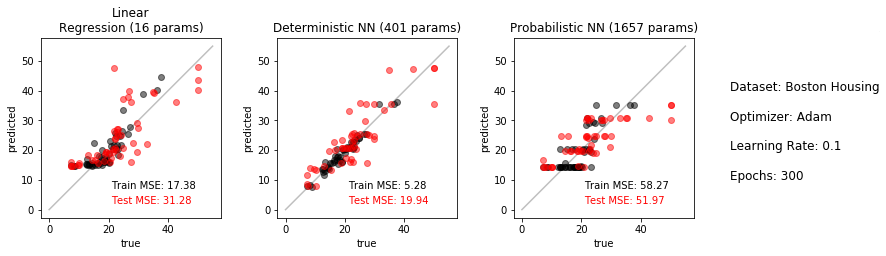

In [9]:
import matplotlib.pyplot as plt
import numpy as np 

N = 50

sample_inputs_train = train[0].sample(N)
sample_outputs_train = train[1].loc[sample_inputs_train.index]
sample_inputs_test = test[0].sample(N)
sample_outputs_test = test[1].loc[sample_inputs_test.index]

colors = ['k','r']
titles = ['Linear\nRegression','Deterministic NN','Probabilistic NN']
plt.figure(figsize = (10,30))
for i,m in enumerate(models):
    plt.subplot(1,len(models),i+1)
    plt.errorbar(sample_outputs_train, m(sample_inputs_train.to_numpy()).numpy(),
    marker = 'o', color = 'k', alpha = 0.5,ls = 'none')
    plt.errorbar(sample_outputs_test, m(sample_inputs_test.to_numpy()).numpy(),
    marker = 'o', color = 'r', alpha = 0.5,ls = 'none')
    plt.title(titles[i] + ' ({} params)'.format(utils.count_parameters(m)))

    xmax = train[1].max()[0]*1.1
    plt.gca().set_aspect('equal')
    plt.plot([0,xmax],[0,xmax],'k',alpha=0.25)
    plt.xlabel('true')
    plt.ylabel('predicted')

    rmse = m.evaluate(x = train[0], y = train[1], verbose=0)
    plt.text(21,7,f"Train MSE: {round(np.sum(rmse), 2)}", color = 'k')
    rmse = m.evaluate(x = test[0], y = test[1], verbose=0)
    plt.text(21,2,f"Test MSE: {round(np.sum(rmse), 2)}", color = 'r')

plt.tight_layout()

plt.text(120, 60, '.', fontsize=1); 
plt.text(70, 40, 'Dataset: '+dataset, fontsize=12)
plt.text(70, 30, 'Optimizer: '+optimizer, fontsize=12)
plt.text(70, 20, 'Learning Rate: '+str(learning_rate), fontsize=12)
plt.text(70, 10, 'Epochs: '+str(epochs), fontsize=12);  